<a href="https://colab.research.google.com/github/bangse94/StudyDL/blob/main/chest_xray_fanogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sejunepark","key":"39e1002dba3d76b0843671a0aa87c2d3"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 30.6MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.7MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/tra

In [5]:
!rm -r /content/chest_xray/chest_xray/train/PNEUMONIA/

In [6]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [7]:
dataroot = "/content/chest_xray/train/"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5
ngpu = 1
#os.listdir("../input/chest_xray/chest_xray/train/PNEUMONIA/")

In [8]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
                    )

    def forward(self, input):
        return self.main(input)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
   
    for i, data in enumerate(dataloader, 0):
        
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device, dtype=torch.float)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/10][0/41]	Loss_D: 2.0170	Loss_G: 4.6887	D(x): 0.5457	D(G(z)): 0.6682 / 0.0157
[1/10][0/41]	Loss_D: 0.3242	Loss_G: 28.5412	D(x): 0.8490	D(G(z)): 0.0000 / 0.0000
[2/10][0/41]	Loss_D: 0.3647	Loss_G: 5.1213	D(x): 0.8156	D(G(z)): 0.0078 / 0.0221
[3/10][0/41]	Loss_D: 0.5044	Loss_G: 4.6998	D(x): 0.7310	D(G(z)): 0.0525 / 0.0150
[4/10][0/41]	Loss_D: 0.3757	Loss_G: 6.3235	D(x): 0.9391	D(G(z)): 0.2504 / 0.0045
[5/10][0/41]	Loss_D: 0.5543	Loss_G: 4.1810	D(x): 0.7989	D(G(z)): 0.2119 / 0.0322
[6/10][0/41]	Loss_D: 1.4211	Loss_G: 8.2932	D(x): 0.8987	D(G(z)): 0.6732 / 0.0027
[7/10][0/41]	Loss_D: 1.1533	Loss_G: 6.9111	D(x): 0.9633	D(G(z)): 0.6006 / 0.0094
[8/10][0/41]	Loss_D: 1.6423	Loss_G: 1.4898	D(x): 0.3516	D(G(z)): 0.0732 / 0.3650
[9/10][0/41]	Loss_D: 1.4610	Loss_G: 1.6809	D(x): 0.3774	D(G(z)): 0.0212 / 0.3057


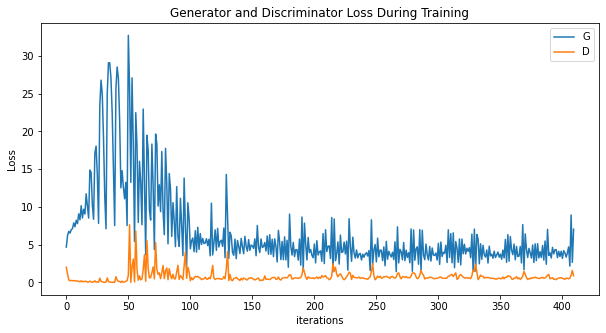

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

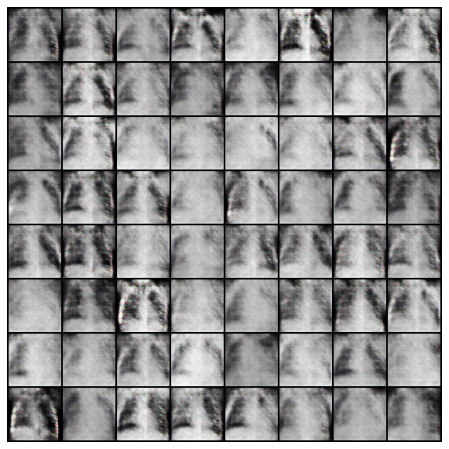

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

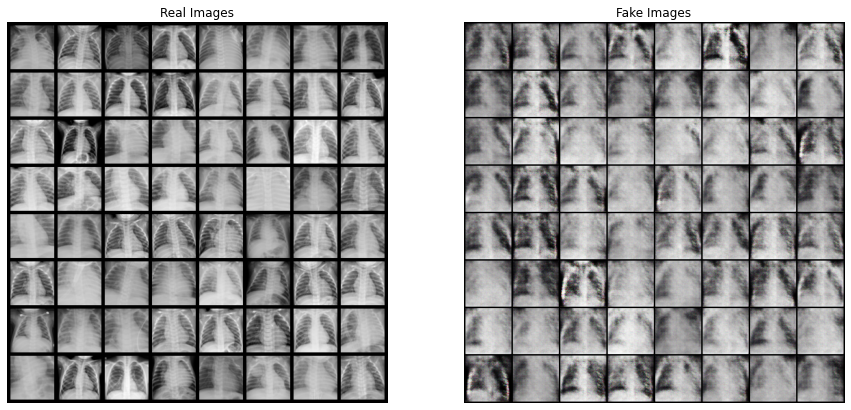

In [15]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [31]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 1, 3, bias = False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*16, nz, 4, 2, 0, bias=False),
            nn.Tanh()
        )


    def forward(self, input):
        return self.main(input)

In [42]:
netE = Encoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netE = nn.DataParallel(netE, list(range(ngpu)))
netE.apply(weights_init)

netG.eval()
netD.eval()

criterion = nn.MSELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0


optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
E_losses = []
iters = 0

for epoch in range(num_epochs):
   
    for i, data in enumerate(dataloader, 0):
        real_image = data[0].to(device)

        optimizerE.zero_grad()
        z = netE(real_image)

        optimizerG.zero_grad()
        fake_image = netG(z)

        real_features = netD(real_image)
        fake_features = netD(fake_image)

        loss_imgs = criterion(real_image, fake_image)
        loss_features = criterion(fake_features, real_features)
        errE = loss_imgs + loss_features

        errE.backward()
        optimizerE.step()
        


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_E: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errE.item()))
        
        E_losses.append(errE.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(netE(netG(fixed_noise))).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/10][0/41]	Loss_E: 0.5133
[1/10][0/41]	Loss_E: 0.1054
[2/10][0/41]	Loss_E: 0.1009
[3/10][0/41]	Loss_E: 0.0952
[4/10][0/41]	Loss_E: 0.0919
[5/10][0/41]	Loss_E: 0.0954
[6/10][0/41]	Loss_E: 0.0856
[7/10][0/41]	Loss_E: 0.0905
[8/10][0/41]	Loss_E: 0.0812
[9/10][0/41]	Loss_E: 0.0885


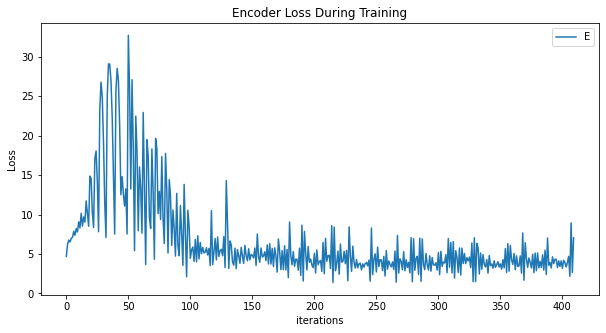

In [43]:
plt.figure(figsize=(10,5))
plt.title("Encoder Loss During Training")
plt.plot(G_losses,label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

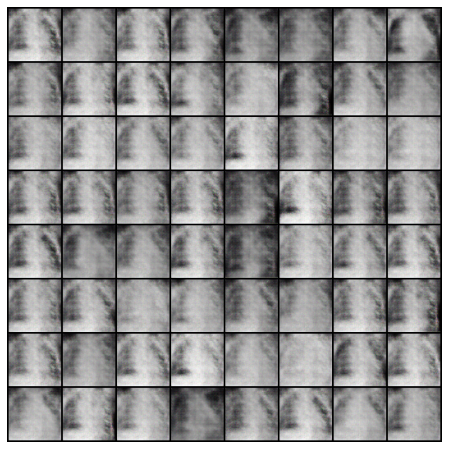

In [44]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

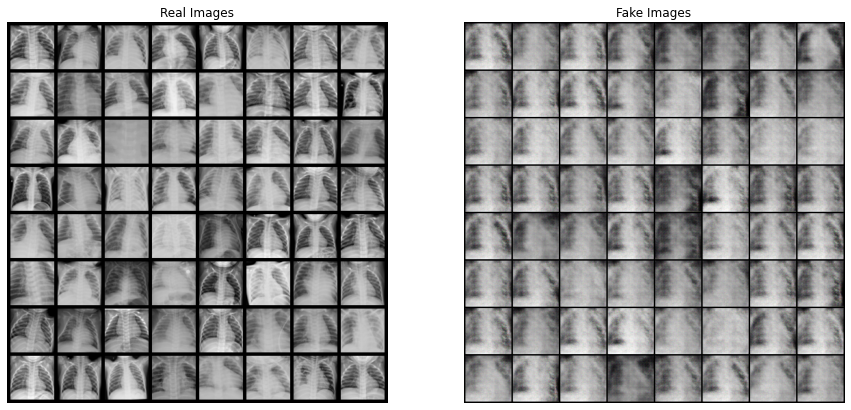

In [45]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()